# Proyecto 3 con KNN 

1) Importación de librerías necesarias:

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
#df = pd.read_csv('data.csv')

In [ ]:
df = df[::960].copy()
df

In [ ]:
df = df.dropna()

In [ ]:
df = df.drop(df.columns[[1,2,3,5,6,7]], axis='columns')
df.rename(columns={"Timestamp": "Date"}, inplace=True)
df

In [ ]:
from datetime import datetime
listaDate = []
for date in df['Date']:
    listaDate.append(datetime.fromtimestamp(date))
df.index = listaDate

In [ ]:
df.index.name="time"
df

In [ ]:
df1 = df.drop(df.columns[[0]], axis='columns')
df1

In [ ]:
df1.to_csv('reducido.csv')
#df5 = df4.filter(like = ('2021-01' and '2021-02'), axis=0)
#df5.to_csv("ene_feb_2021",index=True)

In [ ]:
df2 = pd.read_csv("reducido.csv", delimiter = ",", parse_dates=['time'], index_col='time')
df2.dtypes

In [ ]:
# Forzar gráficos anchos en el notebook de Jupyter
plt.rcParams["figure.figsize"] = (14, 6) # (w, h)
plt.plot(df2)

***

#### En un dataset de valoraciones de Bitcoin, obtener 5 columnas con el delta de los últimos 1, 2, 3, 4 y 5 días.

In [ ]:
# Crear 5 columnas con el delta de los últimos 1, 2, 3, 4 y 5 días
for i in range(1, 6):
    df2[f'delta_{i}d'] = df2['Close'].diff(periods=i)
df2

In [ ]:
# Crear 5 columnas con el delta relativos:
for i in range(1, 6):
    df2[f'delta_relativo_{i}d'] = (df2[f'delta_{i}d']) / (df2['Close'])
df2

In [ ]:
df2.plot()

La valoración tan alta de BTC eclipsa los deltas. Graficamos sólo los deltas:

In [ ]:
df2[['delta_1d', 'delta_2d', 'delta_3d', 'delta_4d', 'delta_5d']].plot()

Graficamos los deltas de forma comparativa con espaciados constantes

Descubriendo zonas de mayor volatilidad, mediante moving average

In [ ]:
plt.plot(abs(df2[['delta_1d']]).rolling(window=16).mean())
plt.plot(df2[['delta_1d']])
plt.plot(df2[['delta_2d']] + 20000)
plt.plot(df2[['delta_3d']] + 40000)
plt.plot(df2[['delta_4d']] + 60000)
plt.plot(df2[['delta_5d']] + 80000)
plt.show()

Análisis de correlación de los deltas

In [ ]:
df2[['delta_1d', 'delta_2d', 'delta_3d', 'delta_4d', 'delta_5d']].corr()

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(df2[['delta_1d', 'delta_2d', 'delta_3d', 'delta_4d', 'delta_5d']].corr(), annot=True)

***

#### Buscar en la gráfica 3 fechas de clara tendencia alcista y 3 de bajista.

Alcista: 

In [ ]:
# Buscar las 3 fechas con el mayor delta_5d, ordenando por esta columna
btc_sorted = df2.sort_values(by='delta_5d', ascending=False)
btc_sorted[:3]

In [ ]:
# Buscar las 3 fechas con el menor delta_5d
btc_sorted[-8:]

***

#### Crear un dataset de entrenamiento con las 6 fechas encontradas y las 5 columnas de deltas.

In [ ]:
# Quito los NaN's
btc_sorted = btc_sorted.dropna()
btc_sorted

In [ ]:
# Dejo sólo las 3 primeras filas y las 3 últimas
# Obtener las 3 primeras filas
btc_sorted_head = btc_sorted.head(3)

# Obtener las 3 últimas filas
btc_sorted_tail = btc_sorted.tail(3)

# Concatenar las primeras y últimas filas
dfTraining = pd.concat([btc_sorted_head, btc_sorted_tail])
dfTraining

***

#### Entrenar KNN con este dataset de entrenamiento

In [ ]:
import numpy as np

# La etiqueta 1 significará alcista y -1 bajista
labels = np.array(['1','1','1','-1','-1','-1'])
labels

In [ ]:
train = np.array(dfTraining[['delta_1d', 'delta_2d', 'delta_3d', 'delta_4d', 'delta_5d']])
# train = train.reshape(-1, 1)
train

***

#### Aplica predicción de KNN para determinar la tendencia alcista/bajista en una fecha dada sobre el dataset completo.

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# inicializar modelo
knn = KNeighborsClassifier(n_neighbors=3)

# entrenar modelo
knn.fit(train, labels)

# evaluar modelo
score = knn.score(train, labels)
print("Precisión del modelo:", score)

In [ ]:
# Datos de test, todo el dataset
dfTesting = btc_sorted
test = np.array(dfTesting[['delta_1d', 'delta_2d', 'delta_3d', 'delta_4d', 'delta_5d']])
test

In [ ]:
predLabel = knn.predict(test)
predLabel

***

#### Dibuja los valores alcistas de Bitcoin en color azul y los bajistas en color rojo

In [ ]:
# Se agrega la predicción como columna nueva en el dataframe
btc_sorted["trend"] = predLabel
btc_sorted

In [ ]:
# Dibujar gráfico de dispersión con color que indica la tendencia predicha por KNN

plt.plot(df2["Close"], color="#999", zorder=1) # zorder sirve para que la línea (plot) quede debajo de los puntos (scatter)

# Para hacer que el color de cada punto se base en la columna trend
# hay que asignar un color rojo o azul según el valor de la columna trend
# en cada fila.

# Plot the data
i=0
for time, row in btc_sorted.iterrows():
    i = i + 1
    #Pintar sólo 1 de cada 10
    if i%10 != 0:
        continue
    if row['trend'] == "1":
        plt.scatter(time, row['Close'], color='blue', s=5, zorder=2)
    else:
        plt.scatter(time, row['Close'], color='red', s=5, zorder=2)

plt.show()

# Moving Average

In [14]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import math

df3 = pd.read_csv("reducido.csv", delimiter = ",", parse_dates=['time'], index_col='time')

<AxesSubplot: xlabel='time'>

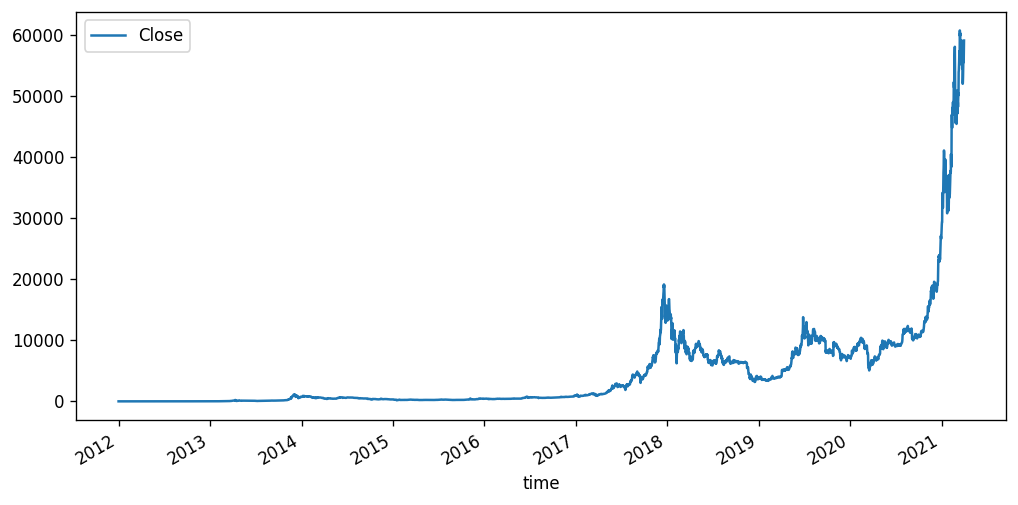

In [15]:
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 120})
df3.plot(kind='line', y='Close')
plt.show

In [16]:
# Crear el modelo ARIMA
model = ARIMA(df3['Close'], order=(0, 1, 1)) #hiperparámetros
model_fit = model.fit()

c:\Users\n_sar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\n_sar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\n_sar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
#Con una ventana de 365 días
df3['MA_365'] = df3['Close'].rolling(window=365).mean()
df3["logPrice"] = df3["Close"].apply(lambda x: math.log10(x))
#df3.head(3)

### Graficamos

In [ ]:
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 120})
plt.figure(figsize=(24,10))
plt.plot(df3['Close'], label = 'Close', color = 'green')
plt.plot(df3['MA_365'], label = 'Moving Average 365 days', color = 'red', linewidth=3)
plt.xlabel('year')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
#ax.scatter(df3.index, df3.MA_365)
ax.scatter(df3.index, df3.logPrice)
#ax.plot(df3)
plt.show()

In [18]:
# dividir los datos en un conjunto de entrenamiento y un conjunto de prueba
train = df3[:int(0.8*(len(df3)))]
test = df3[int(0.8*(len(df3))):]
#print(test)

In [19]:
test

,Close,MA_365,logPrice
time,,,
2019-11-09 20:44:00,8771.46,8352.823918,3.943072
2019-11-10 12:44:00,8844.92,8366.400959,3.946694
2019-11-11 04:44:00,9006.54,8380.411425,3.954558
2019-11-11 20:44:00,8747.99,8393.704795,3.941908
2019-11-12 12:44:00,8733.99,8407.070329,3.941213
...,...,...,...
2021-03-27 20:44:00,55845.41,25049.608795,4.746987
2021-03-28 13:44:00,55908.26,25176.233370,4.747476
2021-03-29 05:44:00,55490.71,25301.235315,4.744220


In [24]:
#predictions = [ [32714], [2837], [48728558]]
test = pd.DataFrame(predictions, columns = ['predictions'])
test

,predictions
0,32714
1,2837
2,48728558


In [ ]:
#Graficar test["prediction"] en el mismo gráfico de antes para poder comparar la predicción con la realidad, 
#a ver cómo consigues colocar esa lista de datos en la nueva columna...
#Aplicar cross validation, ya que ARIMA tiene 3 hiperparámetros.

10) Entrenamiento del modelo

In [20]:
# entrenar el modelo ARIMA
model = ARIMA(train['Close'], order=(1, 0, 1))
model_fit = model.fit()

c:\Users\n_sar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\n_sar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\n_sar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Creación de la columna "prediction" con los datos de la lista "predictions",aplicando el primero a la fecha 2019-11-09, el segundo a 2019-11-10, etc.

In [21]:
# hacer predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))[1]

c:\Users\n_sar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


KeyError: 1

In [22]:
print(predictions)

[[32714], [2837], [48728558]]


In [23]:
# calcular el error de las predicciones
error = np.mean(np.abs(predictions - test['Close'].values)) / np.mean(test['Close'].values)
print('Error:', error)

NameError: name 'np' is not defined

In [ ]:
# visualizar los resultados
plt.plot(train['Close'], label='Datos de entrenamiento')
plt.plot(test['Close'], label='Datos reales')
plt.legend()
plt.show()

In [ ]:
plt.plot(predictions, label='Predicción')